In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.np_utils import to_categorical



# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1:
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3)
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

Using TensorFlow backend.


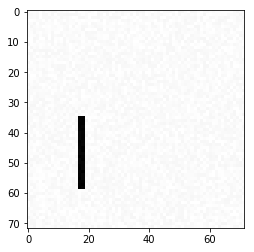

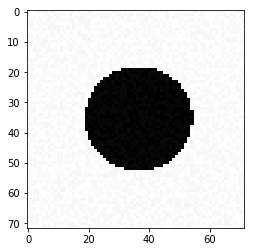

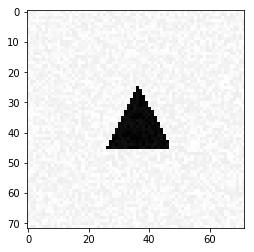

In [2]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

In [3]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [4]:
Y_train_bin = to_categorical(Y_train)

In [5]:
from keras.optimizers import SGD, Adam
sgd = SGD(lr=0.001,
          decay=1e-6,
          momentum=0.9,
          nesterov=True)
adam = Adam(lr=0.0001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=None,
            decay=0.0,
            amsgrad=False)

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation
nb_neurons1 = 3
model = Sequential([
    Dense(nb_neurons1, input_shape=(X_train.shape[1],)),
#     Activation('relu'),
#     Dense(3),
    Activation('softmax'),
])

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer=adam)

In [8]:
epochs=25

In [9]:
model.fit(X_train, Y_train_bin, epochs=epochs, batch_size=32)

Epoch 1/25
300/300 [==============================] - 0s 718us/step - loss: 1.2247
Epoch 2/25
300/300 [==============================] - 0s 138us/step - loss: 1.0159
Epoch 3/25
300/300 [==============================] - 0s 112us/step - loss: 0.9178
Epoch 4/25
300/300 [==============================] - 0s 155us/step - loss: 0.8420
Epoch 5/25
300/300 [==============================] - 0s 177us/step - loss: 0.7613
Epoch 6/25
300/300 [==============================] - 0s 135us/step - loss: 0.7208
Epoch 7/25
300/300 [==============================] - 0s 135us/step - loss: 0.6700
Epoch 8/25
300/300 [==============================] - 0s 150us/step - loss: 0.6242
Epoch 9/25
300/300 [==============================] - 0s 112us/step - loss: 0.5890
Epoch 10/25
300/300 [==============================] - 0s 111us/step - loss: 0.5653
Epoch 11/25
300/300 [==============================] - 0s 137us/step - loss: 0.5484
Epoch 12/25
300/300 [==============================] - 0s 123us/step - loss: 0.5125
E

In [10]:
X_test0 = generate_a_rectangle()
print(X_test0)
X_test0 = X_test0.reshape(1, X_test0.shape[0])
model.predict(X_test0)

[255. 255. 255. ... 255. 255. 255.]


array([[1.0000000e+00, 2.8721112e-35, 0.0000000e+00]], dtype=float32)

In [11]:
X_test2 = generate_a_disk()
print(X_test2)
X_test2 = X_test2.reshape(1, X_test2.shape[0])
model.predict(X_test2)

[255. 255. 255. ... 255. 255. 255.]


array([[0., 1., 0.]], dtype=float32)

In [12]:
X_test1 = generate_a_triangle()[0]
print(X_test1)
X_test1 = X_test1.reshape(1, X_test1.shape[0])
model.predict(X_test1)

[255. 255. 255. ... 255. 255. 255.]


array([[0., 0., 1.]], dtype=float32)

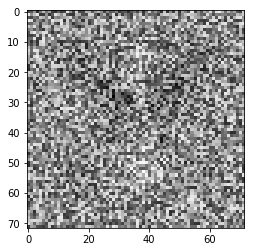

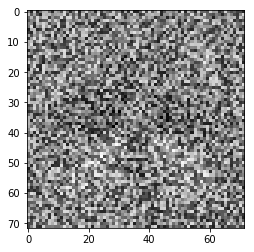

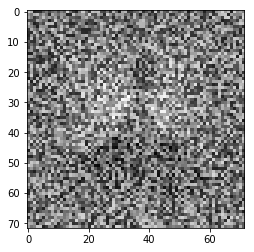

In [13]:
weights = model.get_weights()[0]
for i in range (weights.shape[1]):
    im = weights[:, i]
    plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.show()

In [14]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
             metrics=['accuracy']
             )

In [16]:
model.fit(X_train, Y_train_bin, epochs=epochs, batch_size=32)

Epoch 1/25
300/300 [==============================] - 0s 1ms/step - loss: 1.5549 - acc: 0.3433
Epoch 2/25
300/300 [==============================] - 0s 187us/step - loss: 1.4733 - acc: 0.3600
Epoch 3/25
300/300 [==============================] - 0s 262us/step - loss: 1.5660 - acc: 0.3067
Epoch 4/25
300/300 [==============================] - 0s 183us/step - loss: 1.3810 - acc: 0.3400
Epoch 5/25
300/300 [==============================] - 0s 217us/step - loss: 1.2884 - acc: 0.3933
Epoch 6/25
300/300 [==============================] - 0s 273us/step - loss: 1.2757 - acc: 0.3700
Epoch 7/25
300/300 [==============================] - 0s 168us/step - loss: 1.2554 - acc: 0.3567
Epoch 8/25
300/300 [==============================] - 0s 179us/step - loss: 1.1896 - acc: 0.4000
Epoch 9/25
300/300 [==============================] - 0s 237us/step - loss: 1.2501 - acc: 0.3800
Epoch 10/25
300/300 [==============================] - 0s 172us/step - loss: 1.1625 - acc: 0.4167
Epoch 11/25
300/300 [==========

In [17]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [18]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 232us/step


[1.1550761357943218, 0.33666666587193805]

In [23]:
from keras.layers import Conv2D, MaxPooling2D

# nb_neurons1 = 3
model_conv = Sequential([
#     Dense(nb_neurons1, input_shape=(X_train.shape[1],)),
    Conv2D(16, (5, 5), input_shape=()),
    MaxPooling2D((2, 2)),
    Activation('relu'),
    Dense(3),
    Activation('softmax'),
])

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer=adam)

In [25]:
epochs=25

In [26]:
model.fit(X_train, Y_train_bin, epochs=epochs, batch_size=32)

ValueError: Input 0 is incompatible with layer conv2d_1: expected ndim=4, found ndim=2